In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import qnmfits
import utils

from scipy.interpolate import CubicSpline
from cmcrameri import cm

plt.rcParams.update(utils.rcparams)

In [2]:
t0_M = pd.read_csv('../data/t0_data_30_to_100.csv', index_col=0)
t0_E = pd.read_csv('../data/t0N_E.csv', index_col=0)

Injection based on CCE:01 with only $(2,2,n)$ modes:

In [3]:
injection_info, C, omega = utils.injection(
    ID = 1,
    N = 17,
    tref=t0_M['1'].values[17],
    returnC=True
)
sim = injection_info['sim']

In [4]:
N = 17
modes = [(2, 2, n, 1) for n in range(N+1)]
delta_list = np.linspace(0, 0.2, 100)

In [5]:
epsilon_dict = {}
amplitude_dict = {}

for ntilde in range(N+1):
    epsilon_dict[ntilde] = []
    amplitude_dict[ntilde] = []
    for delta in delta_list:
        frequency_deltas = np.zeros(N+1)
        frequency_deltas[ntilde] = delta
        epsilon, Mf_bestfit, chif_bestfit = qnmfits.calculate_epsilon(
            sim.times, 
            sim.h[2,2], 
            modes, 
            Mf=sim.Mf, 
            chif=sim.chif_mag, 
            t0=t0_M['1'].values[17],
            # t0_method='closest',
            T=70,
            delta=frequency_deltas
        )
        best_fit = qnmfits.ringdown_fit(
            times=sim.times,
            data=sim.h[2,2],
            modes=modes,
            Mf=Mf_bestfit,
            chif=chif_bestfit,
            t0=t0_M['1'].values[17],
            # t0_method='closest',
            T=70,
            delta=frequency_deltas,
        )
        epsilon_dict[ntilde].append(epsilon)
        amplitude_dict[ntilde].append(best_fit['C'])

In [6]:
nt_min = 0
nt_max = 17
nt_list = list(range(nt_min,nt_max+1))

# Create a custom colormap
color_list = [cm.roma(N/20) for N in nt_list]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    None, color_list, N=len(color_list)
    )

In [7]:
deltastar = 0.05

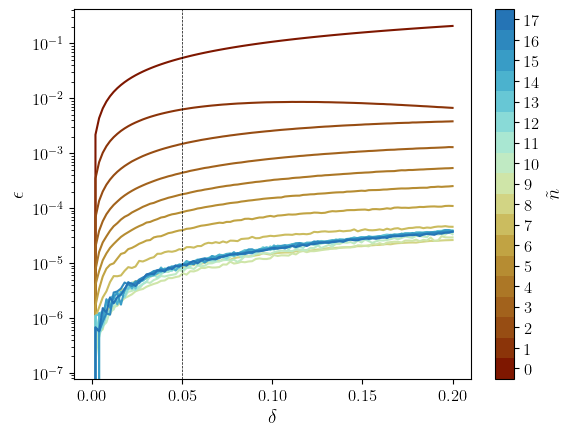

In [8]:
fig, ax = plt.subplots()
ax.set_yscale('log')

# Shift vmin and vmax by 0.5 to center the ticks
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
norm = mpl.colors.Normalize(vmin=nt_min-0.5, vmax=nt_max+0.5)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'$\tilde n$'
    )

for ntilde in range(N+1):
    ax.plot(
        delta_list, 
        epsilon_dict[ntilde], 
        color=cmap(ntilde)
    )
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$\epsilon$')

ax.axvline(deltastar, color='k', linestyle='--', lw=0.5);

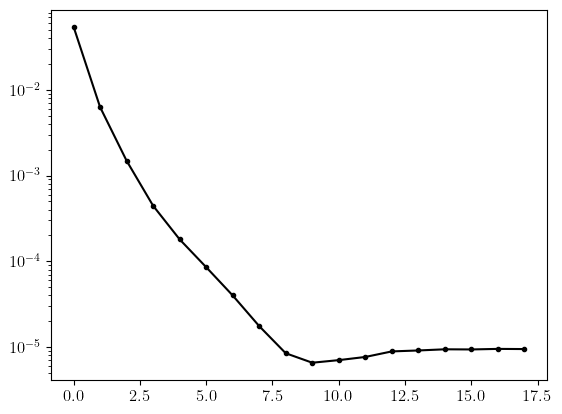

In [9]:
fig, ax = plt.subplots()
ax.set_yscale('log')

epsilon_at_deltastar = [
    epsilon_dict[ntilde][np.argmin(np.abs(delta_list - deltastar))] 
    for ntilde in range(N+1)
]

ax.plot(
    nt_list,
    epsilon_at_deltastar,
    marker='o',
    color='k',
    linestyle='-',
    markersize=3,
);

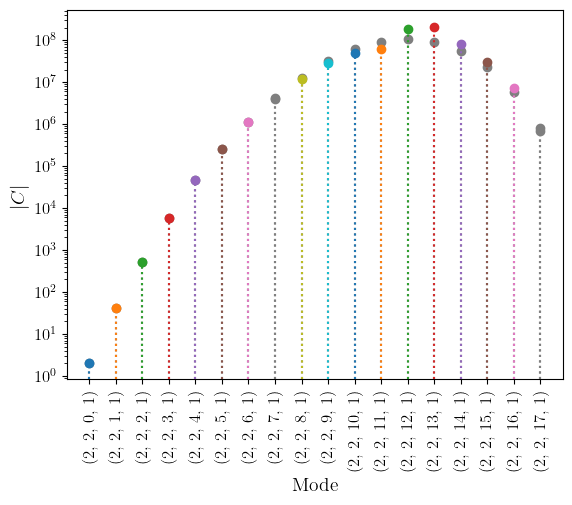

In [10]:
# Get the amplitudes from the complex coefficients
amplitudes_true = abs(C)

# x-axis values, useful for plotting
x = np.arange(len(amplitudes_true))

fig, ax = plt.subplots()
ax.set_yscale('log')

for i in range(len(amplitudes_true)):
    ax.plot(
        [x[i],x[i]], 
        [0,amplitudes_true[i]], 
        color='C7', 
        marker='o', 
        markevery=(1,2), 
        linestyle=':'
    )

# Pick which mode to perturb here and plot the corresponding amplitudes
amplitudes = abs(amplitude_dict[12][np.argmin(np.abs(delta_list-deltastar))])
# amplitudes = abs(best_fit_test['C'])

for i in range(len(amplitudes)):
    ax.plot(
        [x[i],x[i]], 
        [0,amplitudes[i]], 
        color=f'C{i}', 
        marker='o', 
        markevery=(1,2), 
        linestyle=':'
    )

ax.set_xticks(x)
ax.set_xticklabels(best_fit['mode_labels'])
ax.tick_params(axis='x', rotation=90)

ax.set_xlabel('Mode')
ax.set_ylabel('$|C|$');

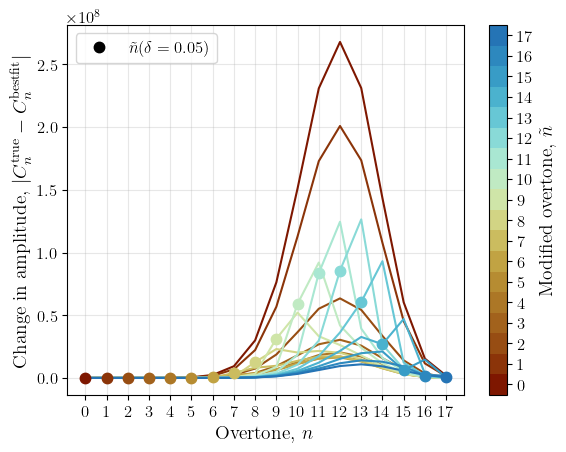

In [11]:
fig, ax = plt.subplots()
ax.grid(visible=True, alpha=0.3)
# ax.set_yscale('log')

for ntilde in range(N+1):
    amplitudes = amplitude_dict[ntilde][np.argmin(np.abs(delta_list - deltastar))]
    dA = abs(amplitudes - C)
    ax.plot(x, dA, color=cmap(ntilde), markersize=3)
    ax.plot([ntilde], [dA[ntilde]], 'o', color=cmap(ntilde), markersize=7.5, zorder=5)

ax.set_xticks(x)

ax.set_xlabel(r'Overtone, $n$')
ax.set_ylabel(r'Change in amplitude, $|C_n^\mathrm{true} - C_n^\mathrm{bestfit}|$')

handles = [
    plt.Line2D(
        [], 
        [], 
        color='k', 
        marker='o', 
        lw=0,
        markersize=7.5, 
        label=r'$\tilde{n}(\delta = ' f'{deltastar})$'
    )
]
ax.legend(handles=handles, loc='upper left')

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'Modified overtone, $\tilde n$'
)   

In [12]:
relative_error_dict = {}
for ntilde in range(N+1):
    relative_error_dict[ntilde] = []
    for i in range(len(delta_list)):
        relative_error_dict[ntilde].append(
            np.sqrt(np.sum((np.abs(amplitude_dict[ntilde][i] - C) / np.abs(C))**2))
        )

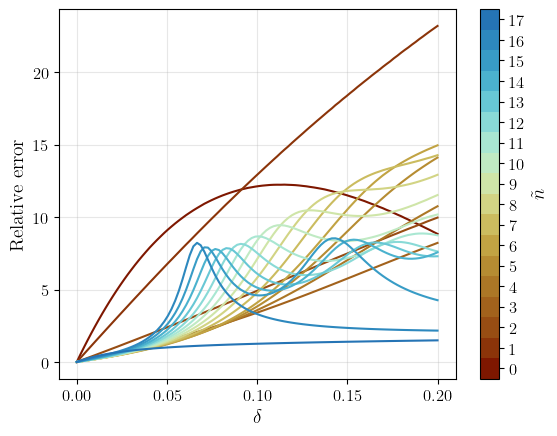

In [13]:
fig, ax = plt.subplots()
ax.grid(visible=True, alpha=0.3)

for ntilde in range(N+1):
    ax.plot(
        delta_list, 
        relative_error_dict[ntilde], 
        color=cmap(ntilde)
    )

ax.set_xlabel(r'$\delta$')
ax.set_ylabel('Relative error')

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'$\tilde n$'
)

One interesting feature here is that epsilon doesn't actually get any better when we modify $n > 9$. The below code generates heatmaps to inspect what's happening:

In [ ]:
Mf_minmax=(sim.Mf-5e-5, sim.Mf+5e-5)
chif_minmax=(sim.chif_mag-5e-5, sim.chif_mag+5e-5)

delta = deltastar
ntilde = 8
frequency_deltas = np.zeros(N+1)
frequency_deltas[ntilde] = delta

mm_grid = qnmfits.mismatch_M_chi_grid(
    times=sim.times,
    data=sim.h[2,2],
    modes=modes,
    Mf_minmax=Mf_minmax,
    chif_minmax=chif_minmax,
    t0=t0_M['1'].values[17],
    T=70,
    # t0_method='closest',
    delta=frequency_deltas
)

min_index = np.unravel_index(np.argmin(mm_grid), mm_grid.shape)
mm_grid[min_index]

Mf_array = np.linspace(*Mf_minmax, 50)
chif_array = np.linspace(*chif_minmax, 50)

Mf_bf = Mf_array[min_index[0]]
chif_bf = chif_array[min_index[1]]

qnmfits.plot_mismatch_M_chi_grid(
    mm_grid, 
    Mf_minmax=Mf_minmax,
    chif_minmax=chif_minmax,
    truth=(sim.Mf, sim.chif_mag),
    marker=(Mf_bf, chif_bf),
)

Repeat for CCE:01

In [14]:
N = 17
modes = [(2, 2, n, 1) for n in range(N+1)]
delta_list = np.linspace(0, 0.2, 100)

In [15]:
sim_info = utils.load_cce_data(1)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

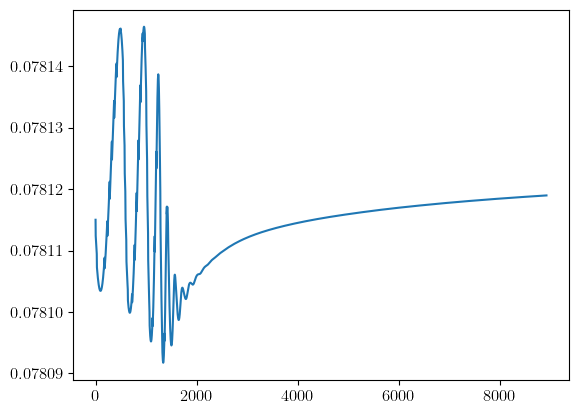

In [16]:
# The default spacing is ~0.08
plt.plot(np.diff(sim.times));

In [17]:
len(sim.times)

8929

In [18]:
# I get improved stability if I downsample the data slightly
spl = CubicSpline(sim.times, sim.h[2,2])
sparse_times = np.linspace(sim.times[0], sim.times[-1], 7000)
sparse_h = spl(sparse_times)

We also need to fit for (3,2,0):

In [19]:
N = 17
modes = [(2, 2, n, 1) for n in range(N+1)]

In [20]:
epsilon_dict = {}
amplitude_dict = {}

for ntilde in range(N+1):
    epsilon_dict[ntilde] = []
    amplitude_dict[ntilde] = []
    for delta in delta_list:
        frequency_deltas = np.zeros(N+2)
        frequency_deltas[ntilde] = delta
        epsilon, Mf_bestfit, chif_bestfit = qnmfits.calculate_epsilon(
            times=sim.times,
            data=sim.h[2,2], 
            modes=modes+[(3,2,0,1)],
            Mf=sim.Mf, 
            chif=sim.chif_mag, 
            t0=t0_M['1'].values[17],
            # t0_method='closest',
            T=70,
            delta=frequency_deltas
        )
        best_fit = qnmfits.ringdown_fit(
            times=sim.times,
            data=sim.h[2,2], 
            modes=modes+[(3,2,0,1)],
            Mf=Mf_bestfit,
            chif=chif_bestfit,
            t0=t0_M['1'].values[17],
            # t0_method='closest',
            T=70,
            delta=frequency_deltas,
        )

        epsilon_dict[ntilde].append(epsilon)
        amplitude_dict[ntilde].append(best_fit['C'])

In [21]:
epsilon_dict_sparse = {}
amplitude_dict_sparse = {}

for ntilde in range(N+1):
    epsilon_dict_sparse[ntilde] = []
    amplitude_dict_sparse[ntilde] = []
    for delta in delta_list:
        frequency_deltas = np.zeros(N+2)
        frequency_deltas[ntilde] = delta
        epsilon, Mf_bestfit, chif_bestfit = qnmfits.calculate_epsilon(
            times=sparse_times,
            data=sparse_h,
            modes=modes+[(3,2,0,1)],
            Mf=sim.Mf, 
            chif=sim.chif_mag, 
            t0=t0_M['1'].values[17],
            # t0_method='closest',
            T=70,
            delta=frequency_deltas
        )
        best_fit = qnmfits.ringdown_fit(
            times=sparse_times,
            data=sparse_h,
            modes=modes+[(3,2,0,1)],
            Mf=Mf_bestfit,
            chif=chif_bestfit,
            t0=t0_M['1'].values[17],
            # t0_method='closest',
            T=70,
            delta=frequency_deltas,
        )

        epsilon_dict_sparse[ntilde].append(epsilon)
        amplitude_dict_sparse[ntilde].append(best_fit['C'])

In [22]:
t0_M['1'].values[17]

np.float64(-8.826296198236378)

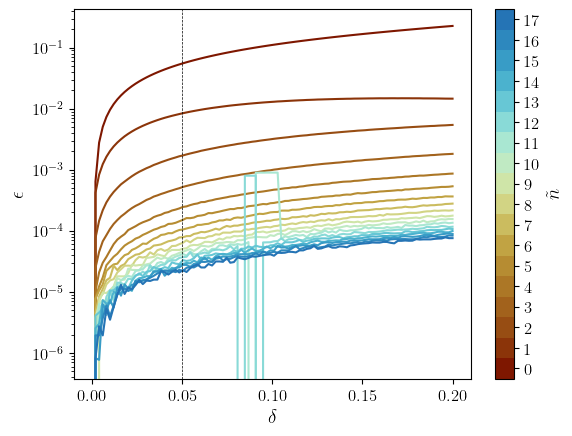

In [23]:
fig, ax = plt.subplots()
ax.set_yscale('log')

# Shift vmin and vmax by 0.5 to center the ticks
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
norm = mpl.colors.Normalize(vmin=nt_min-0.5, vmax=nt_max+0.5)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'$\tilde n$'
    )

for ntilde in range(N+1):
    ax.plot(
        delta_list, 
        epsilon_dict[ntilde] - epsilon_dict[ntilde][0], 
        color=cmap(ntilde)
    )
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$\epsilon$')

ax.axvline(0.05, color='k', linestyle='--', lw=0.5);

In [24]:
nt_min = 0
nt_max = 17
nt_list = list(range(nt_min,nt_max+1))

# Create a custom colormap
color_list = [cm.batlow(N/17) for N in nt_list]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    None, color_list, N=len(color_list)
    )

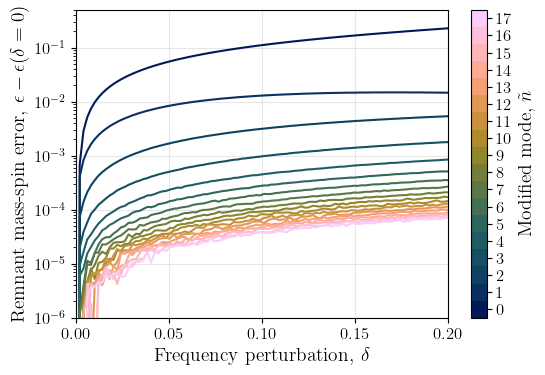

In [25]:
fig, ax = plt.subplots(figsize=(6,4))

ax.grid(visible=True, alpha=0.3)

ax.set_yscale('log')

# Shift vmin and vmax by 0.5 to center the ticks
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
norm = mpl.colors.Normalize(vmin=nt_min-0.5, vmax=nt_max+0.5)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'Modified mode, $\tilde n$'
    )

for ntilde in range(N+1):
    ax.plot(
        delta_list, 
        epsilon_dict_sparse[ntilde] - epsilon_dict_sparse[ntilde][0], 
        color=cmap(ntilde)
    )

ax.set_xlabel(r'Frequency perturbation, $\delta$')
ax.set_ylabel('Remnant mass-spin error, $\epsilon - \epsilon(\delta = 0)$')

ax.set_xlim(0, 0.2)
ax.set_ylim(1e-6)

# ax.axvline(0.05, color='k', linestyle='--', lw=0.5);

fig.savefig('figures/presentation/frequency_perturbations.png', dpi=300, bbox_inches='tight')

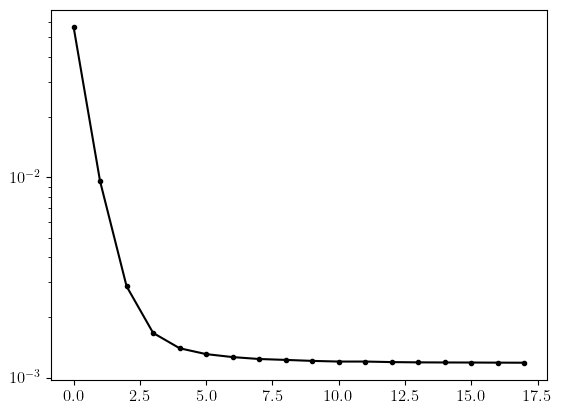

In [26]:
fig, ax = plt.subplots()
ax.set_yscale('log')

deltastar = 0.05

epsilon_at_deltastar = [
    epsilon_dict_sparse[ntilde][np.argmin(np.abs(delta_list - deltastar))] 
    for ntilde in range(N+1)
]

ax.plot(
    nt_list,
    epsilon_at_deltastar,
    marker='o',
    color='k',
    linestyle='-',
    markersize=3,
);

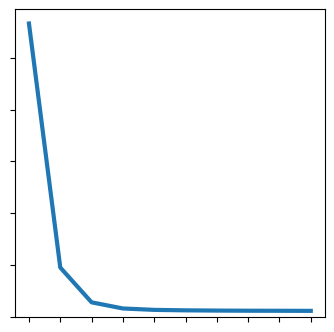

In [27]:
fig, ax = plt.subplots(figsize=(4,4))
# ax.set_yscale('log')

deltastar = 0.05

epsilon_at_deltastar = [
    epsilon_dict_sparse[ntilde][np.argmin(np.abs(delta_list - deltastar))] 
    for ntilde in range(N+1)
]

ax.plot(
    nt_list[:10],
    epsilon_at_deltastar[:10],
    lw=3,
    color='C0'
)

ax.set_ylim(0)

ax.set_xticks(nt_list[:10])
ax.set_xticklabels([])
ax.set_yticklabels([])

fig.savefig('figures/presentation/frequency_perturbations_overview.png', dpi=300, bbox_inches='tight')

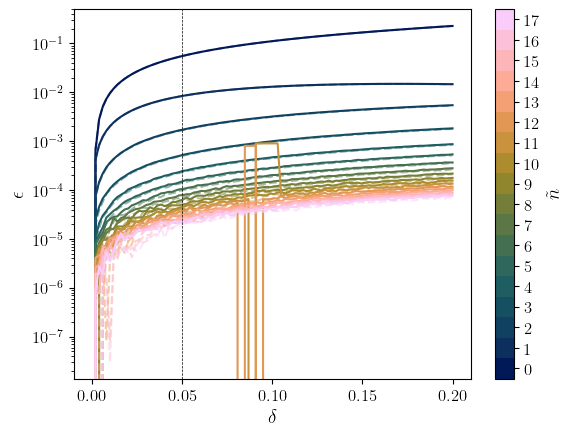

In [28]:
fig, ax = plt.subplots()
ax.set_yscale('log')

# Shift vmin and vmax by 0.5 to center the ticks
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
norm = mpl.colors.Normalize(vmin=nt_min-0.5, vmax=nt_max+0.5)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'$\tilde n$'
    )

for ntilde in range(N+1):
    ax.plot(
        delta_list, 
        epsilon_dict[ntilde] - epsilon_dict[ntilde][0], 
        color=cmap(ntilde)
    )
    ax.plot(
        delta_list, 
        epsilon_dict_sparse[ntilde] - epsilon_dict_sparse[ntilde][0], 
        color=cmap(ntilde),
        ls='--',
        alpha=0.5
    )

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$\epsilon$')

ax.axvline(0.05, color='k', linestyle='--', lw=0.5);

In [29]:
C_delta_zero = amplitude_dict_sparse[0][0]
x = np.arange(N+1)

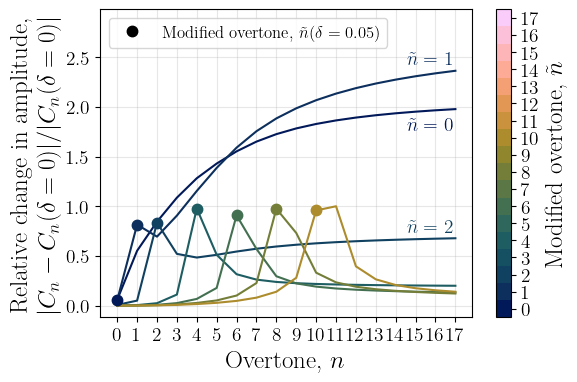

In [30]:
fig, ax = plt.subplots(figsize=(6,4))
ax.grid(visible=True, alpha=0.3)
# ax.set_yscale('log')

for ntilde in [0, 1, 2, 4, 6, 8, 10]: # range(N+1):
    amplitudes = amplitude_dict_sparse[ntilde][np.argmin(abs(delta_list - deltastar))]
    dA = abs(amplitudes - C_delta_zero)[:-1]
    dA /= np.abs(C_delta_zero)[:-1]
    ax.plot(x, dA, color=cmap(ntilde), markersize=3)
    ax.plot([ntilde], [dA[ntilde]], 'o', color=cmap(ntilde), markersize=7.5, zorder=5)

ax.set_xticks(x)

ax.set_xlabel(r'Overtone, $n$', fontsize=18)
ax.set_ylabel('Relative change in amplitude,\n' r'$|C_n - C_n(\delta = 0)|/|C_n(\delta = 0)|$', fontsize=18)

handles = [
    plt.Line2D(
        [], 
        [], 
        color='k', 
        marker='o', 
        lw=0,
        markersize=7.5, 
        # label=r'$\tilde{n}(\delta = ' f'{deltastar})$'
        label=r'Modified overtone, $\tilde{n}(\delta = ' f'{deltastar})$'
    )
]
ax.legend(handles=handles, loc='upper left')

ax.text(
    0.95, 0.65, 
    r'$\tilde{n} = 0$', 
    transform=ax.transAxes, 
    va='top', ha='right',
    color=cmap(0)
)

ax.text(
    0.95, 0.865, 
    r'$\tilde{n} = 1$', 
    transform=ax.transAxes, 
    va='top', ha='right',
    color=cmap(1)
)

ax.text(
    0.95, 0.32, 
    r'$\tilde{n} = 2$', 
    transform=ax.transAxes, 
    va='top', ha='right',
    color=cmap(2)
)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'Modified overtone, $\tilde n$'
)   

cbar.ax.set_ylabel(r'Modified overtone, $\tilde n$', fontsize=18)
cbar.ax.tick_params(labelsize=14)

# print(ax.get_ylim())
ax.set_ylim((np.float64(-0.11808635168609972), np.float64(2.982259160018509)))

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

fig.savefig('figures/presentation/amplitude_perturbations_0_altc.png', dpi=300, bbox_inches='tight')

In [31]:
nt_min = 0
nt_max = 17
nt_list = list(range(nt_min,nt_max+1))

# Create a custom colormap
color_list = [cm.batlow(N/17) for N in nt_list]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    None, color_list, N=len(color_list)
    )

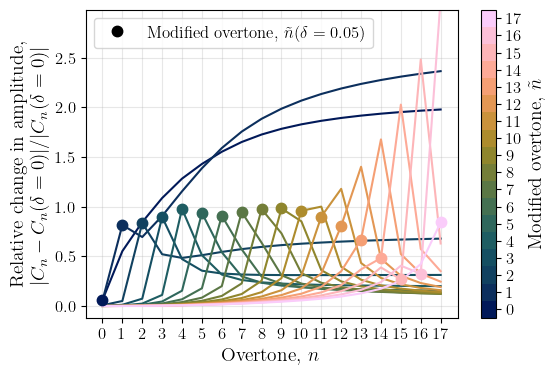

In [32]:
fig, ax = plt.subplots(figsize=(6,4))
ax.grid(visible=True, alpha=0.3)
# ax.set_yscale('log')

for ntilde in range(N+1):
    amplitudes = amplitude_dict_sparse[ntilde][np.argmin(abs(delta_list - deltastar))]
    dA = abs(amplitudes - C_delta_zero)[:-1]
    dA /= np.abs(C_delta_zero)[:-1]
    ax.plot(x, dA, color=cmap(ntilde), markersize=3)
    ax.plot([ntilde], [dA[ntilde]], 'o', color=cmap(ntilde), markersize=7.5, zorder=5)

ax.set_xticks(x)

ax.set_xlabel(r'Overtone, $n$')
ax.set_ylabel('Relative change in amplitude,\n' r'$|C_n - C_n(\delta = 0)|/|C_n(\delta = 0)|$')

handles = [
    plt.Line2D(
        [], 
        [], 
        color='k', 
        marker='o', 
        lw=0,
        markersize=7.5, 
        # label=r'$\tilde{n}(\delta = ' f'{deltastar})$'
        label=r'Modified overtone, $\tilde{n}(\delta = ' f'{deltastar})$'
    )
]
ax.legend(handles=handles, loc='upper left')

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'Modified overtone, $\tilde n$'
)   

# print(ax.get_ylim())
ax.set_ylim((np.float64(-0.11808635168609972), np.float64(2.982259160018509)))

fig.savefig('figures/presentation/amplitude_perturbations_0_altc_all.png', dpi=300, bbox_inches='tight')

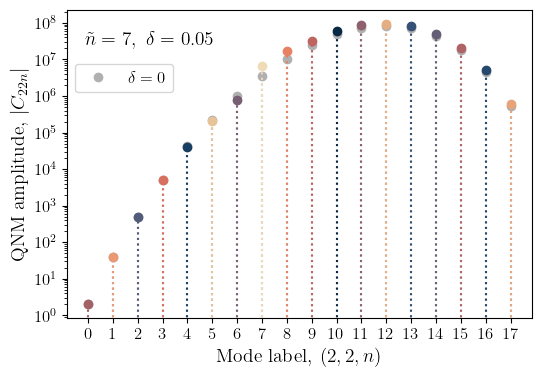

In [33]:
# Get the amplitudes from the complex coefficients
amplitudes_true = abs(C_delta_zero)[:-1]

# x-axis values, useful for plotting
x = np.arange(len(amplitudes_true))

fig, ax = plt.subplots(figsize=(6,4))
ax.set_yscale('log')

for i in range(len(amplitudes_true)):
    ax.plot(
        [x[i],x[i]], 
        [0,amplitudes_true[i]], 
        color="#B0B0B0", 
        marker='o', 
        markevery=(1,2), 
        linestyle=':'
    )

ntilde = 7
# Pick which mode to perturb here and plot the corresponding amplitudes
amplitudes = amplitude_dict_sparse[ntilde][np.argmin(abs(delta_list - deltastar))][:-1]

for i in range(len(amplitudes)):
    c = cm.lipariS(i+2)
    ax.plot(
        [x[i],x[i]], 
        [0,np.abs(amplitudes[i])], 
        color=c, 
        marker='o', 
        markevery=(1,2), 
        linestyle=':'
    )

ax.set_xticks(x)
# ax.tick_params(axis='x', rotation=90)

ax.text(
    0.04, 
    0.93, 
    r'$\tilde{n} = 7,\ \delta = 0.05$', 
    transform=ax.transAxes, 
    va='top', 
    ha='left'
)

handles = [
    plt.Line2D(
        [], 
        [], 
        color='#B0B0B0',
        marker='o',
        lw=0,
    )
]
labels = [
    r'$\delta = 0$'
]
ax.legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(0.0, 0.85),
    # frameon=False,
)

ax.set_xlabel(r'Mode label, $(2,2,n)$')
ax.set_ylabel(r'QNM amplitude, $|C_{22n}|$')

fig.savefig(
    'figures/presentation/amplitude_perturbations_needle.png', 
    dpi=300, 
    bbox_inches='tight'
)

In [34]:
relative_error_dict = {}
for ntilde in range(N+1):
    relative_error_dict[ntilde] = []
    for i in range(len(delta_list)):
        relative_error_dict[ntilde].append(
            np.sqrt(np.sum((np.abs(amplitude_dict_sparse[ntilde][i] - C_delta_zero) / np.abs(C_delta_zero))**2))
        )

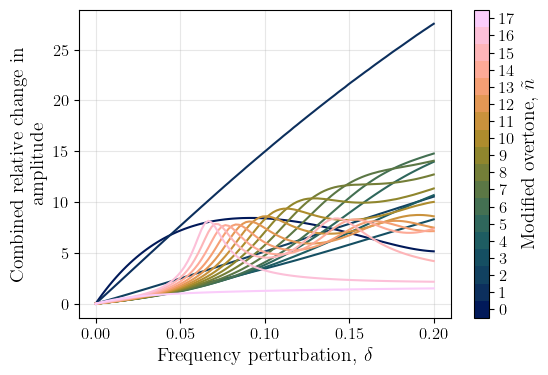

In [35]:
fig, ax = plt.subplots(figsize=(6,4))
ax.grid(visible=True, alpha=0.3)

for ntilde in range(N+1):
    ax.plot(
        delta_list, 
        relative_error_dict[ntilde], 
        color=cmap(ntilde)
    )

ax.set_xlabel(r'Frequency perturbation, $\delta$')
ax.set_ylabel('Combined relative change in\namplitude')

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'Modified overtone, $\tilde n$'
)

fig.savefig('figures/presentation/combined_amplitude_change.png', dpi=300, bbox_inches='tight')

In [36]:
N = 10
modes = [(2, 2, n, 1) for n in range(N+1)]
t0 = t0_M['1'].values[N]
delta_list = np.linspace(0, 0.2, 100)

In [37]:
epsilon_dict = {}
amplitude_dict = {}

for ntilde in range(N+1):
    epsilon_dict[ntilde] = []
    amplitude_dict[ntilde] = []
    for delta in delta_list:
        frequency_deltas = np.zeros(N+2)
        frequency_deltas[ntilde] = delta
        epsilon, Mf_bestfit, chif_bestfit = qnmfits.calculate_epsilon(
            times=sim.times,
            data=sim.h[2,2], 
            modes=modes+[(3,2,0,1)],
            Mf=sim.Mf, 
            chif=sim.chif_mag, 
            t0=t0,
            # t0_method='closest',
            T=70,
            delta=frequency_deltas
        )
        best_fit = qnmfits.ringdown_fit(
            times=sim.times,
            data=sim.h[2,2], 
            modes=modes+[(3,2,0,1)],
            Mf=Mf_bestfit,
            chif=chif_bestfit,
            t0=t0,
            # t0_method='closest',
            T=70,
            delta=frequency_deltas,
        )
        epsilon_dict[ntilde].append(epsilon)
        amplitude_dict[ntilde].append(best_fit['C'])

In [38]:
nt_min = 0
nt_max = 10
nt_list = list(range(nt_min,nt_max+1))

# Create a custom colormap
color_list = [cm.batlow(N/10) for N in nt_list]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    None, color_list, N=len(color_list)
    )

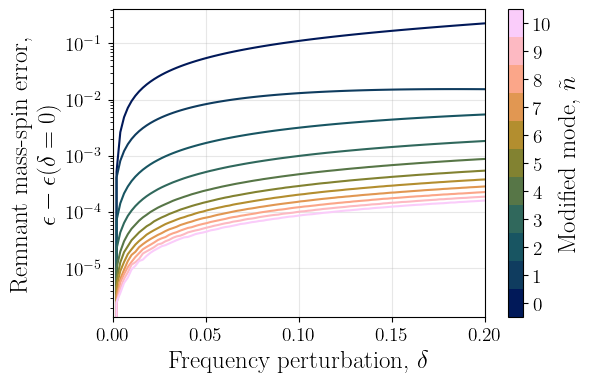

In [39]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_yscale('log')

ax.grid(visible=True, alpha=0.3)

# Shift vmin and vmax by 0.5 to center the ticks
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
norm = mpl.colors.Normalize(vmin=nt_min-0.5, vmax=nt_max+0.5)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'Modified mode, $\tilde n$',
    )

cbar.ax.set_ylabel(r'Modified mode, $\tilde n$', fontsize=18)
cbar.ax.tick_params(labelsize=14)

for ntilde in range(N+1):
    ax.plot(
        delta_list, 
        epsilon_dict[ntilde] - epsilon_dict[ntilde][0], 
        color=cmap(ntilde)
    )
ax.set_xlabel(r'Frequency perturbation, $\delta$', fontsize=18)
ax.set_ylabel('Remnant mass-spin error, \n$\epsilon - \epsilon(\delta = 0)$', fontsize=18)

ax.set_xlim(0, 0.2)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

fig.savefig('figures/presentation/frequency_perturbations_N10_altaltc.png', dpi=300, bbox_inches='tight')

In [41]:
t0

np.float64(-3.8278624238555494)

In [42]:
C_delta_zero = amplitude_dict[0][0]
x = np.arange(N+1)

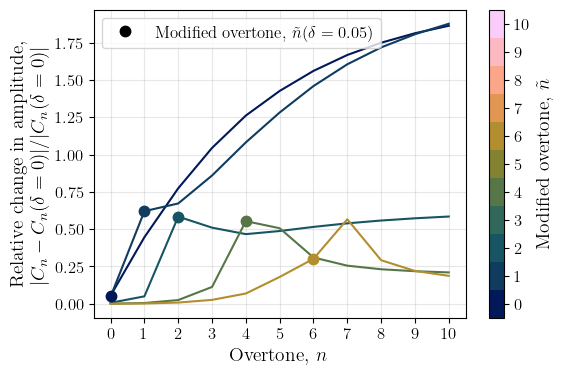

In [43]:
fig, ax = plt.subplots(figsize=(6,4))
ax.grid(visible=True, alpha=0.3)
# ax.set_yscale('log')

for ntilde in [0, 1, 2, 4, 6]: # range(N+1):
    amplitudes = amplitude_dict[ntilde][np.argmin(abs(delta_list - deltastar))]
    dA = abs(amplitudes - C_delta_zero)[:-1]
    dA /= np.abs(C_delta_zero)[:-1]
    ax.plot(x, dA, color=cmap(ntilde), markersize=3)
    ax.plot([ntilde], [dA[ntilde]], 'o', color=cmap(ntilde), markersize=7.5, zorder=5)

ax.set_xticks(x)

ax.set_xlabel(r'Overtone, $n$')
ax.set_ylabel('Relative change in amplitude,\n' r'$|C_n - C_n(\delta = 0)|/|C_n(\delta = 0)|$')

handles = [
    plt.Line2D(
        [], 
        [], 
        color='k', 
        marker='o', 
        lw=0,
        markersize=7.5, 
        # label=r'$\tilde{n}(\delta = ' f'{deltastar})$'
        label=r'Modified overtone, $\tilde{n}(\delta = ' f'{deltastar})$'
    )
]
ax.legend(handles=handles, loc='upper left')

# ax.text(
#     0.95, 0.65, 
#     r'$\tilde{n} = 0$', 
#     transform=ax.transAxes, 
#     va='top', ha='right',
#     color=cmap(0)
# )

# ax.text(
#     0.95, 0.865, 
#     r'$\tilde{n} = 1$', 
#     transform=ax.transAxes, 
#     va='top', ha='right',
#     color=cmap(1)
# )

# ax.text(
#     0.95, 0.32, 
#     r'$\tilde{n} = 2$', 
#     transform=ax.transAxes, 
#     va='top', ha='right',
#     color=cmap(2)
# )

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'Modified overtone, $\tilde n$'
)   

# print(ax.get_ylim())
# ax.set_ylim((np.float64(-0.11808635168609972), np.float64(2.982259160018509)))

fig.savefig('figures/presentation/amplitude_perturbations_N10_altaltc.png', dpi=300, bbox_inches='tight')

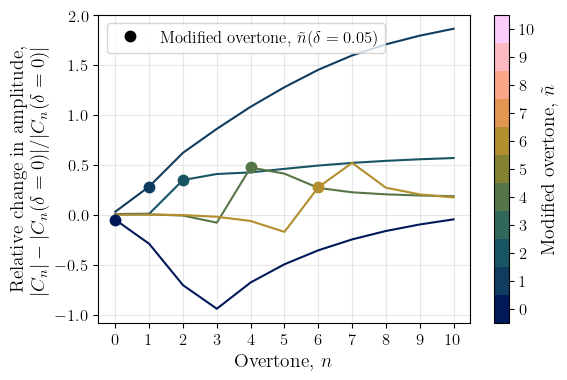

In [44]:
fig, ax = plt.subplots(figsize=(6,4))
ax.grid(visible=True, alpha=0.3)
# ax.set_yscale('log')

for ntilde in [0, 1, 2, 4, 6]: # range(N+1):
    amplitudes = amplitude_dict[ntilde][np.argmin(abs(delta_list - deltastar))]
    dA = abs(amplitudes)[:-1] - np.abs(C_delta_zero)[:-1]
    dA /= np.abs(C_delta_zero)[:-1]
    ax.plot(x, dA, color=cmap(ntilde), markersize=3)
    ax.plot([ntilde], [dA[ntilde]], 'o', color=cmap(ntilde), markersize=7.5, zorder=5)

ax.set_xticks(x)

ax.set_xlabel(r'Overtone, $n$')
ax.set_ylabel('Relative change in amplitude,\n' r'$|C_n| - |C_n(\delta = 0)|/|C_n(\delta = 0)|$')

handles = [
    plt.Line2D(
        [], 
        [], 
        color='k', 
        marker='o', 
        lw=0,
        markersize=7.5, 
        # label=r'$\tilde{n}(\delta = ' f'{deltastar})$'
        label=r'Modified overtone, $\tilde{n}(\delta = ' f'{deltastar})$'
    )
]
ax.legend(handles=handles, loc='upper left')

# ax.text(
#     0.95, 0.65, 
#     r'$\tilde{n} = 0$', 
#     transform=ax.transAxes, 
#     va='top', ha='right',
#     color=cmap(0)
# )

# ax.text(
#     0.95, 0.865, 
#     r'$\tilde{n} = 1$', 
#     transform=ax.transAxes, 
#     va='top', ha='right',
#     color=cmap(1)
# )

# ax.text(
#     0.95, 0.32, 
#     r'$\tilde{n} = 2$', 
#     transform=ax.transAxes, 
#     va='top', ha='right',
#     color=cmap(2)
# )

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, 
    ticks=range(nt_min, nt_max+1),
    label=r'Modified overtone, $\tilde n$'
)   

# print(ax.get_ylim())
# ax.set_ylim((np.float64(-0.11808635168609972), np.float64(2.982259160018509)))

fig.savefig('figures/presentation/amplitude_perturbations_N10_altaltc_alt.png', dpi=300, bbox_inches='tight')